# Examles of error propigation
Examples are taken from http://ipl.physics.harvard.edu/wp-uploads/2013/03/PS3_Error_Propagation_sp13.pdf and used on MCMC to show how the answers work

## Example 1

Example: suppose you measure the height H of a door and get 2.00 ± 0.03 m. This means that
H = 2.00 m and δH = 0.03 m. The door has a knob which is a height h = 0.88 ± 0.04 m from the bottom
of the door. Then the distance from the doorknob to the top of the door is Q = H − h = 1.12 m. What
is the uncertainty in Q?

Q = 1.12 ± 0.05 m


In [1]:
import numpy as np
import pymc3 as pm
import seaborn as sns
import arviz as ar

sns.set(font_scale=1.5)
%matplotlib inline

This version uses prior distributions to do all the work. H and h are both informative priors that then drive the solution to the right answer. 

In [2]:


with pm.Model() as model:

    H = pm.Normal('H', 2.00, sigma=0.03)
    h = pm.Normal('h', 0.88, sigma=0.04)
    Q = pm.Deterministic('Q', H-h)
    trace = pm.sample(10000)

    

/home/balarsen/miniconda3/envs/python3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h, H]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 25 seconds.


In [9]:
with model:
    print(pm.summary(trace).round(3))


    mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean   ess_sd  \
H  2.000  0.030   1.943    2.056        0.0      0.0   36063.0  36043.0   
h  0.881  0.041   0.806    0.958        0.0      0.0   36946.0  36870.0   
Q  1.119  0.050   1.024    1.212        0.0      0.0   36457.0  36457.0   

   ess_bulk  ess_tail  r_hat  
H   36049.0   28849.0    1.0  
h   36938.0   28038.0    1.0  
Q   36468.0   29223.0    1.0  


MCMC gives 1.12 +/- 0.05, analytic gives 1.12 +/- 0.05


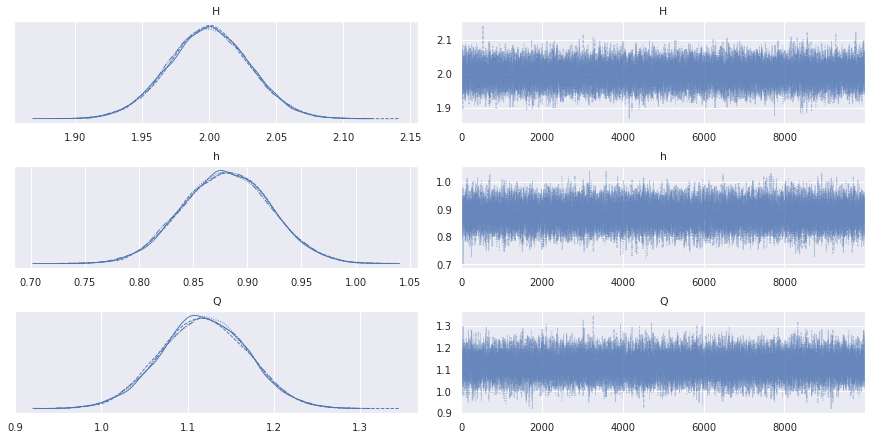

In [10]:
with model:
    pm.traceplot(trace, combined=False)
    print("MCMC gives {:.2f} +/- {:.2f}, analytic gives {} +/- {}".format(trace['Q'].mean(), 
                                                                          trace['Q'].std(), 1.12, 0.05))

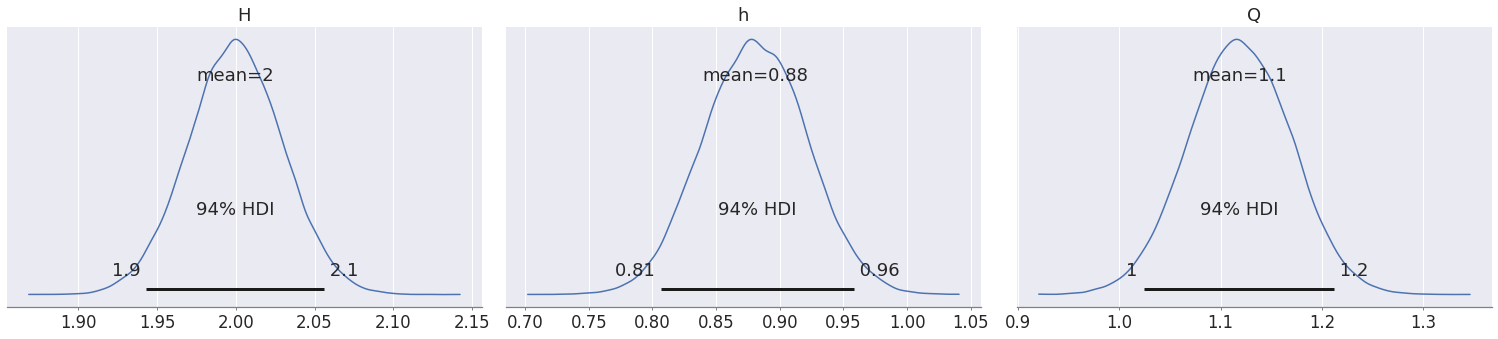

In [13]:
with model:
    pm.plot_posterior(trace)

## Example 2

Example: a bird flies a distance d = 120 ± 3 m during a time t = 20.0 ± 1.2 s. The average speed of
the bird is v = d/t = 6 m/s. What is the uncertainty of v?

0.39 m/s.

In [14]:
with pm.Model() as model:
    d = pm.Normal('d', 123, tau=(3)**-2)
    t = pm.Normal('t', 20.0, tau=(1.2)**-2)
    v = pm.Deterministic('v', d/t)
    trace = pm.sample(40000, chains=4)

/home/balarsen/miniconda3/envs/python3/lib/python3.8/site-packages/pymc3/sampling.py:465: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t, d]


Sampling 4 chains for 1_000 tune and 40_000 draw iterations (4_000 + 160_000 draws total) took 74 seconds.


In [15]:
with model:
    print(pm.summary(trace).round(3))

      mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean    ess_sd  \
d  122.990  3.003  117.299  128.595      0.008    0.006  138444.0  138444.0   
t   20.000  1.203   17.751   22.265      0.003    0.002  137592.0  137592.0   
v    6.172  0.405    5.434    6.942      0.001    0.001  135291.0  134047.0   

   ess_bulk  ess_tail  r_hat  
d  138460.0  114974.0    1.0  
t  137597.0  115575.0    1.0  
v  136478.0  115483.0    1.0  


MCMC gives 0.41, analytic gives 0.39


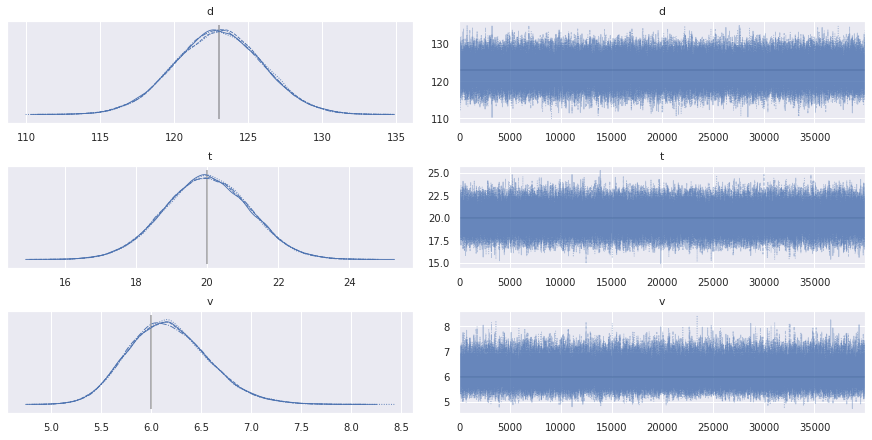

In [16]:
with model:
    pm.traceplot(trace, combined=False, lines=[('d', {}, 123), ('t', {}, 20), ('v', {}, 6)])
    print("MCMC gives {0:.2f}, analytic gives {1}".format(trace['v'].std(), 0.39))

## Example 3

Example: the period of an oscillation is measured to be T = 0.20 ± 0.01 s. Thus the frequency is
f = 1/T = 5 Hz. What is the uncertainty in f? Answer: the percent uncertainty in T was 0.01/0.20 = 5%.
Thus the percent uncertainty in f is also 5%, which means that δf = 0.25 Hz. So f = 5.0 ± 0.3 Hz (after
rounding).

f = 5.0 ± 0.3 Hz

In [18]:
with pm.Model() as model:
    T = pm.Normal('T', 0.20, tau=(0.01)**-2)

    pm.Deterministic('1/T', 1/T)

    trace = pm.sample(10000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [T]
Sampling 2 chains: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22000/22000 [00:06<00:00, 3206.22draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000268B3855C18>,
      dtype=object)

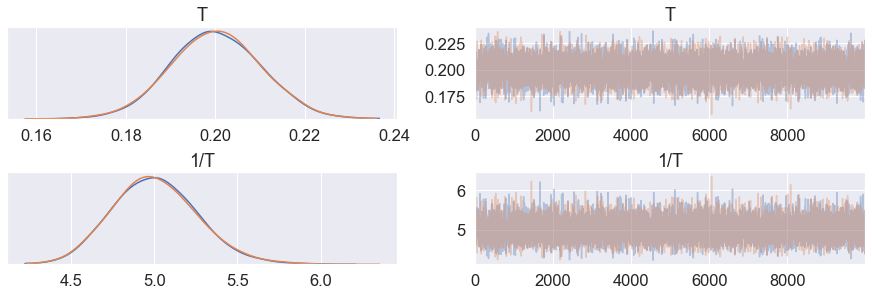

In [19]:
pm.traceplot(trace, combined=False)

In [21]:
pm.summary(trace).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
T,0.200,0.010,0.000,0.181,0.220,8069.658,1.0
1/T,5.008,0.252,0.003,4.531,5.508,8129.352,1.0


In [22]:
print("MCMC gives {0:.1f} +/- {1:.1f}, analytic gives {2} +/- {3}".format(np.mean(trace['1/T']), 
                                                                          np.std(trace['1/T']), 
                                                                          5.0, 0.3))


MCMC gives 5.0 +/- 0.3, analytic gives 5.0 +/- 0.3


## Example 4

Example: a ball is tossed straight up into the air with initial speed v0 = 4.0 ± 0.2 m/s. After a time
t = 0.60±0.06 s, the height of the ball is y = v0t−
1
2
gt2 = 0.636 m. What is the uncertainty of y? Assume
g = 9.80 m/s2
(no uncertainty in g).

Thus y would be properly reported as 0.6 ± 0.4 m.

In [24]:
with pm.Model() as model:
    g = 9.80
    t = pm.Normal('t', 0.60, tau=(0.06)**-2)
    v0 = pm.Normal('v0', 4.0, tau=(0.2)**-2)

    h = pm.Deterministic('h', v0*t - 0.5*g*t**2)

    trace = pm.sample(10000)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v0, t]
Sampling 2 chains: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21000/21000 [00:06<00:00, 3000.31draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000268ACBE2BA8>,
      dtype=object)

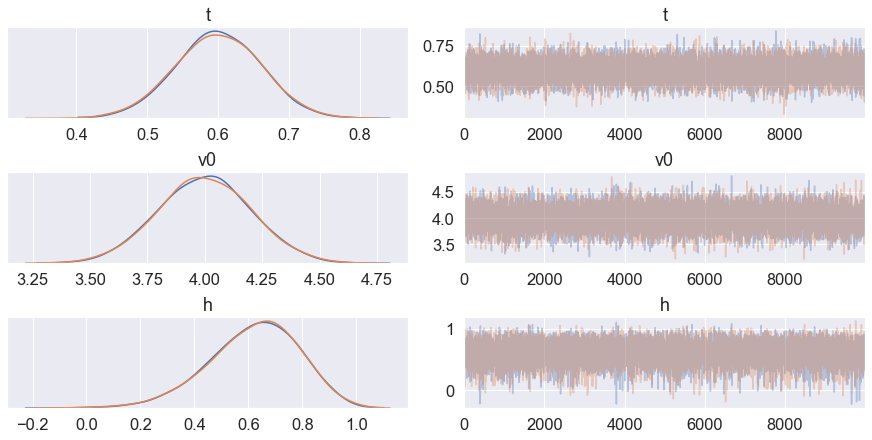

In [25]:
pm.traceplot(trace, combined=False)

In [26]:
pm.summary(trace).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
t,0.600,0.060,0.000,0.485,0.720,19741.060,1.0
v0,4.000,0.201,0.001,3.603,4.392,20554.703,1.0
h,0.618,0.169,0.001,0.272,0.917,18990.477,1.0


In [27]:
print("MCMC gives {0:.1f} +/- {1:.1f}, analytic gives {2} +/- {3}".format(np.mean(trace['h']), 
                                                                          np.std(trace['h']), 
                                                                          0.6, 0.4))


MCMC gives 0.6 +/- 0.2, analytic gives 0.6 +/- 0.4


## Example 5
For example, suppose Ann and Billy both measure the speed of a moving ball. Ann measures 3.6±0.2 m/s
and Billy gets 3.3 ± 0.3 m/s. Do the two measurements agree?

D = 0.3 ± 0.4 m/s  so 0 is in the range, they do agree.

In [34]:
with pm.Model() as model:

    A = pm.Normal('A', 3.6, tau=(0.2)**-2)
    B = pm.Normal('B', 3.3, tau=(0.3)**-2)

    D = pm.Deterministic('D', A-B)

    trace = pm.sample(1000, chains=6)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 2 jobs)
NUTS: [B, A]
Sampling 6 chains: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9000/9000 [00:04<00:00, 2244.90draws/s]


In [35]:
pm.summary(trace).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
A,3.600,0.202,0.002,3.192,3.969,6468.645,1.0
B,3.294,0.304,0.004,2.701,3.888,6367.768,1.0
D,0.306,0.366,0.004,-0.434,1.008,6609.139,1.0


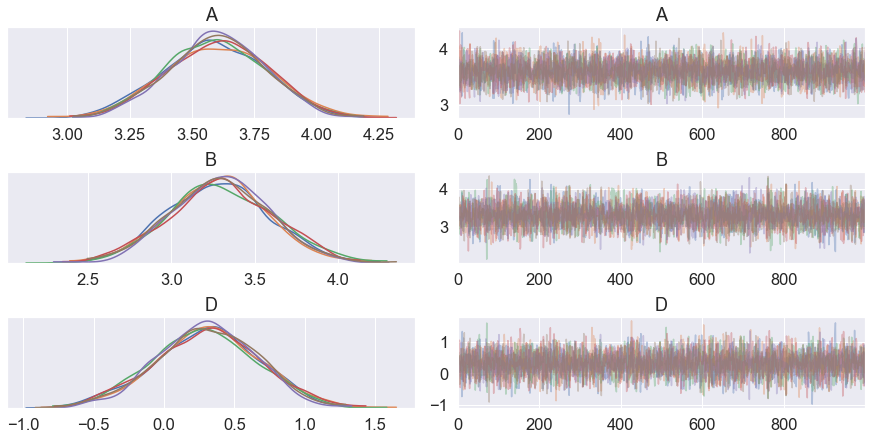

In [36]:
pm.traceplot(trace, combined=False);

In [37]:
print("MCMC gives {0:.1f} +/- {1:.1f}, analytic gives {2} +/- {3}".format(np.mean(trace['D']), 
                                                                          np.std(trace['D']), 
                                                                          0.3, 0.4))


MCMC gives 0.3 +/- 0.4, analytic gives 0.3 +/- 0.4


## Acceleration due to graving example
$g=\frac{2h}{t^2}$

In [10]:
data = [.22, .23, .21, .22]

with pm.Model() as model:

    h = pm.Normal('h', 1.0, sigma=0.01)
    t = pm.Normal('t', 2.2, sigma=1, observed=data)
    g = pm.Deterministic('g', 2*h/t**2)
    trace = pm.sample(10000)

    

<ipython-input-10-7638ff20201e>:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(10000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [h]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 17 seconds.


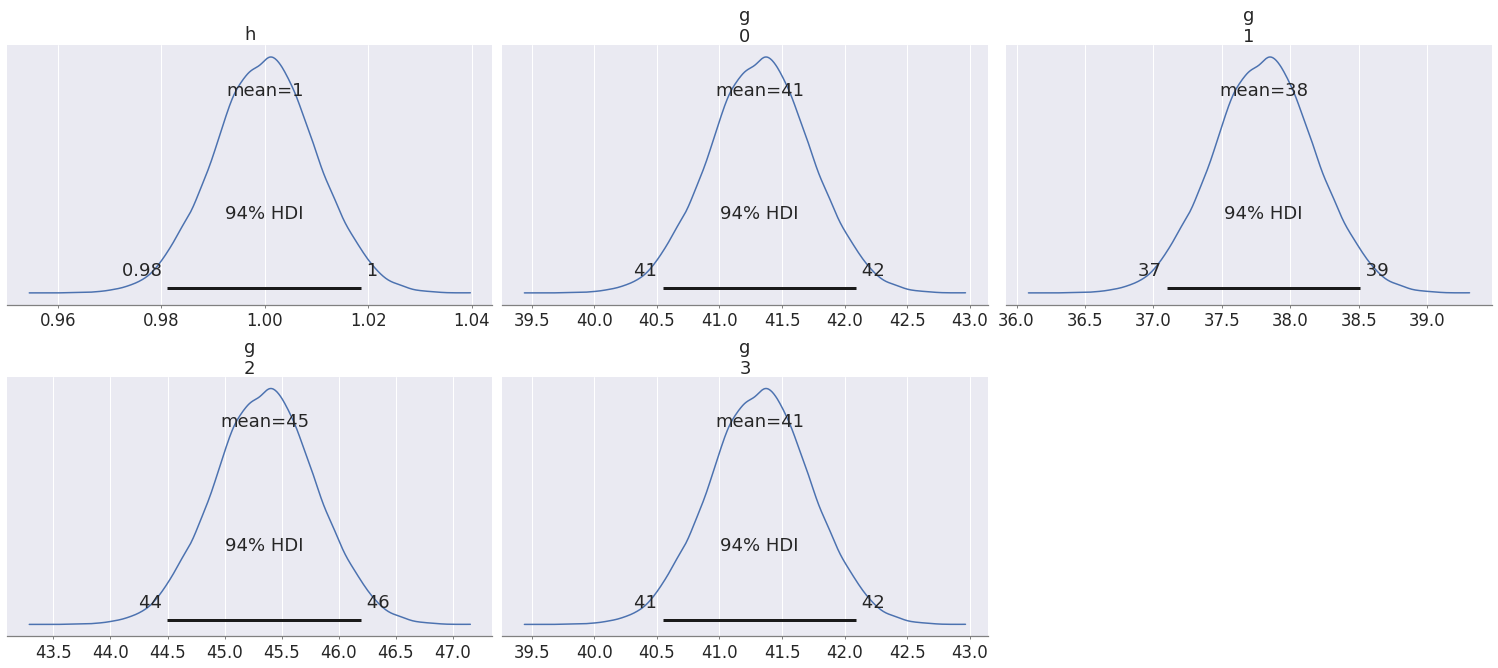

In [11]:
with model:
    pm.plot_posterior(trace, com==)

In [12]:
pm.plot_posterior?